In [65]:
import numpy as np
import regex as re
import pandas as pd
import gc
import logging
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
import string
import nltk as nlp
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, KeyedVectors
#from gensim.test.utils import common_texts
#from collections import Counter #like map but worse cuz it senses only the tally --> not for computation :(
from tensorflow.python.client import device_lib
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

In [66]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12221015915883888299
]


In [67]:
print(tf.test.is_built_with_cuda())

True


#### LOADING IMDB DATASET

In [68]:
dataframe = pd.read_csv('C:/Users/KAMALI/Downloads/IMDB Dataset.csv/IMDB Dataset.csv')

In [69]:
dataframe.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [70]:
dataframe.describe()

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

In [71]:
np.shape(dataframe)

(50000, 2)

In [72]:
dataframe['sentiment'] = dataframe['sentiment'].replace('positive', 1)
dataframe['sentiment'] = dataframe['sentiment'].replace('negative', 0)
dataframe.head()
#in case of non-binary classes it makes more sense to use label encoder rather than replace

review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1

#### EXPLORATORY DATA ANALYSIS (BEFORE PREPROCESSING)

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\KAMALI\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


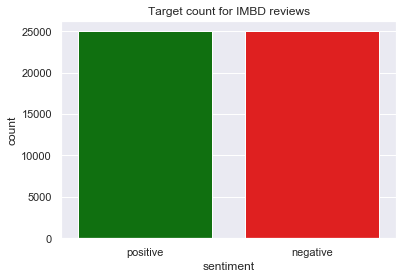

In [74]:
### Count Plot
sns.set(style = "darkgrid" , font_scale = 1,palette='deep',color_codes=True)
sns.countplot(dataframe.sentiment,palette = ['green','red'],order = [1,0])
plt.xticks(ticks = np.arange(2),labels = ['positive','negative'])
plt.title('Target count for IMBD reviews')
plt.show()

In [75]:
print('Positive reviews are', (round(dataframe['sentiment'].value_counts()[1])),'i.e.', round(dataframe['sentiment'].value_counts()[0]/len(dataframe) * 100,2), '% of the dataset')
print('Negative reviews are', (round(dataframe['sentiment'].value_counts()[0])),'i.e.',round(dataframe['sentiment'].value_counts()[1]/len(dataframe) * 100,2), '% of the dataset')

Positive reviews are 25000 i.e. 50.0 % of the dataset
Negative reviews are 25000 i.e. 50.0 % of the dataset


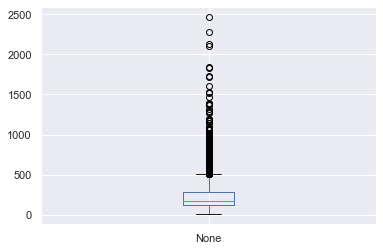

In [76]:
# Calculate review lengths
review_len = pd.Series([len(review.split()) for review in dataframe['review']])

# The distribution of review text lengths
review_len.plot(kind='box')

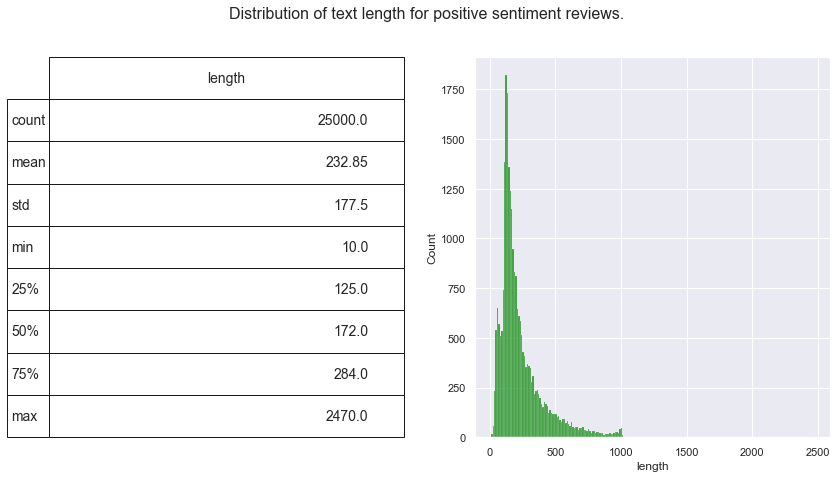

In [77]:
fig = plt.figure(figsize=(14,7))
dataframe['length'] = dataframe.review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(dataframe[dataframe['sentiment']==1]['length'], ax=ax1,color='green')
describe = dataframe.length[dataframe.sentiment==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment reviews.', fontsize=16)

plt.show()

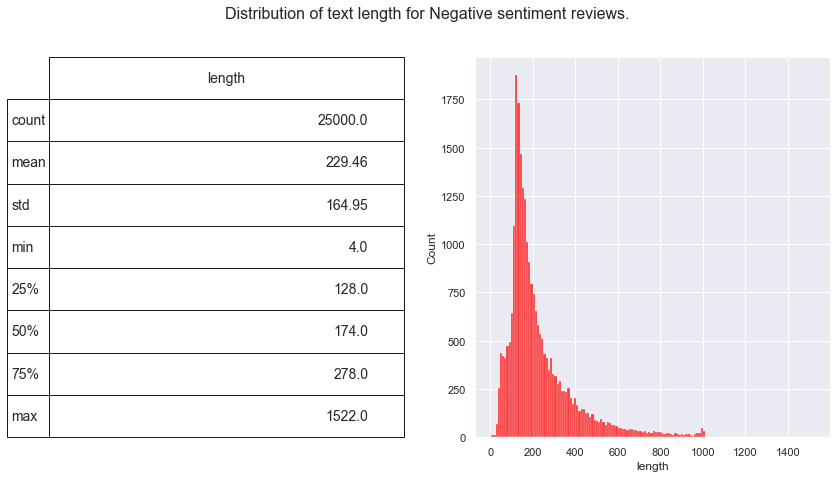

In [78]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(dataframe[dataframe['sentiment']==0]['length'], ax=ax1,color='red')
describe = dataframe.length[dataframe.sentiment==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment reviews.', fontsize=16)

plt.show()

In [79]:
from wordcloud import WordCloud

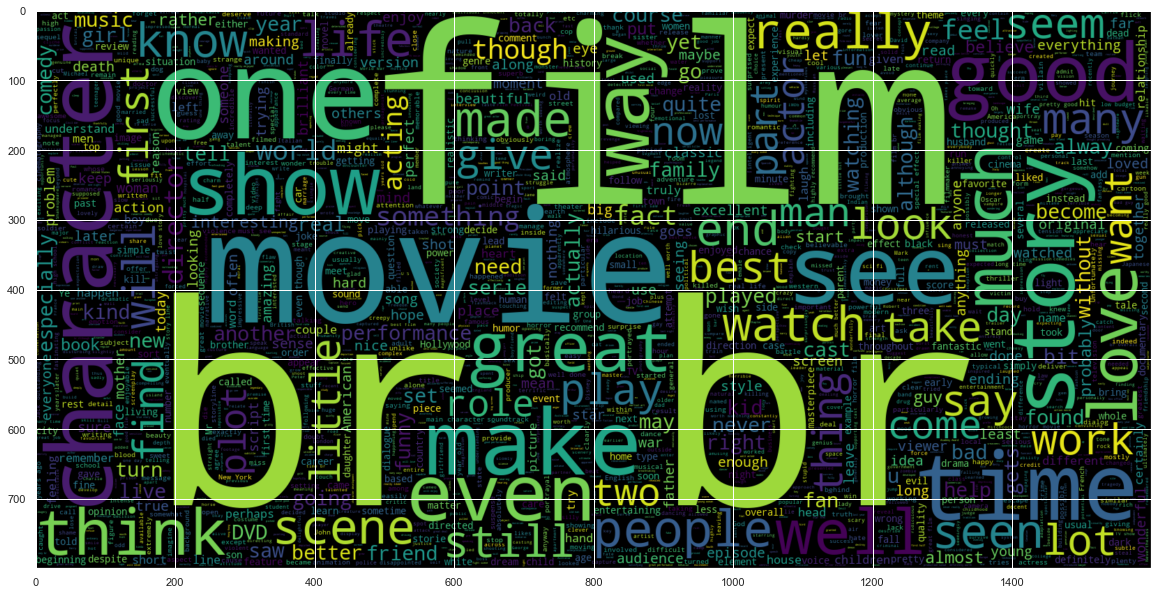

In [80]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dataframe[dataframe.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

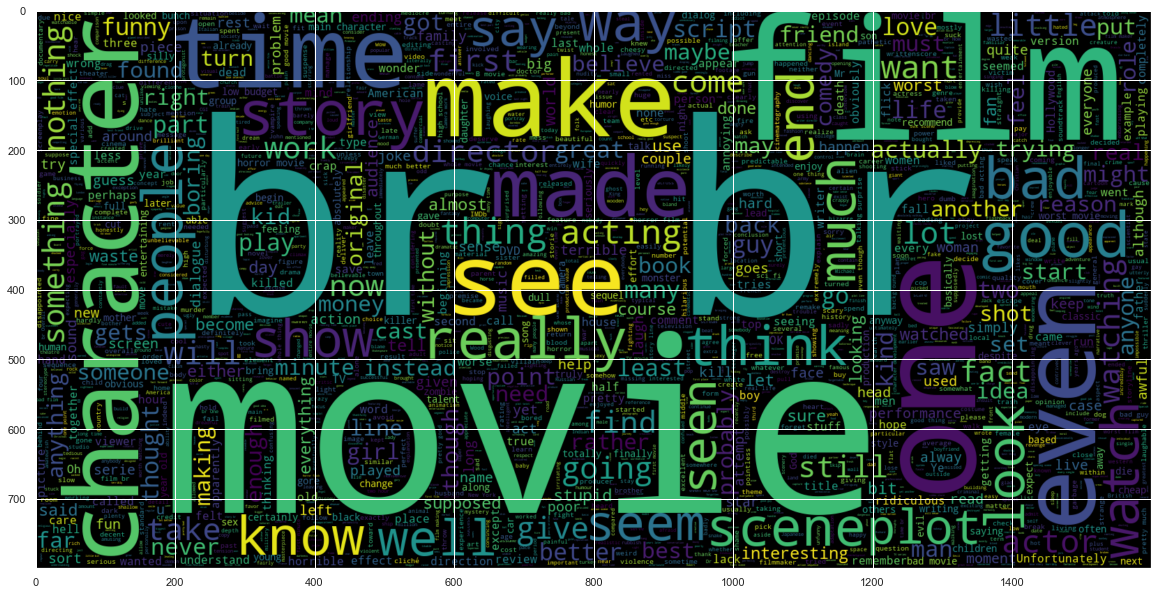

In [81]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dataframe[dataframe.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

In [82]:
positive_data = dataframe[dataframe.sentiment == 1]['review']
negative_data = dataframe[dataframe.sentiment == 0]['review']

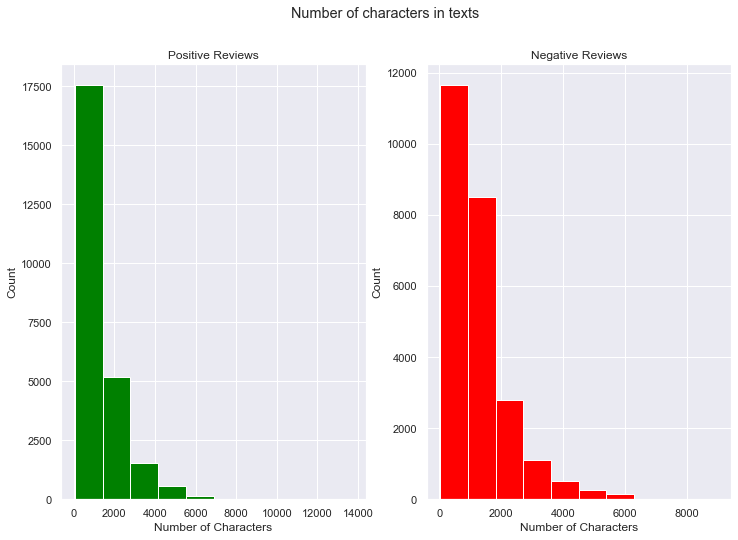

In [83]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Count')
fig.suptitle('Number of characters in texts')
plt.show()

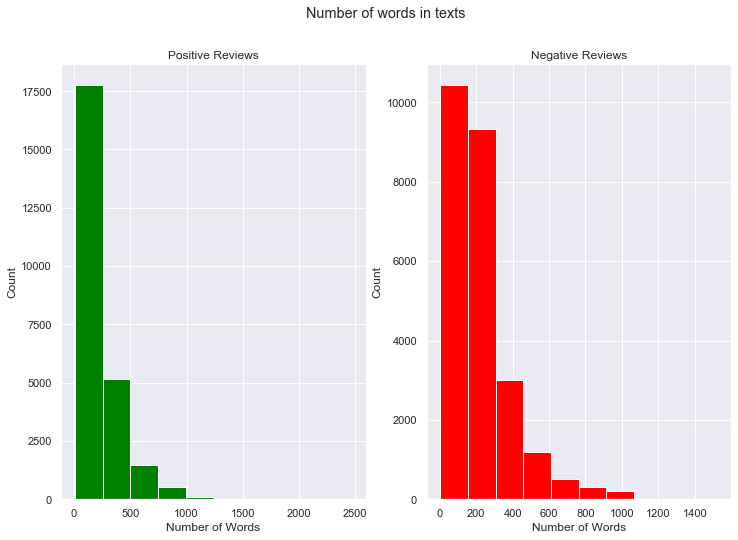

In [84]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in texts')
plt.show()

In [85]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(dataframe.review)

In [86]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

corpus  countv
0    the  568735
1      a  306960
2    and  301919
3     of  283625
4     to  261850
5     is  203056
6     in  169981
7      I  132498
8   that  126818
9   this  113726

In [87]:
most_common = most_common.sort_values('countv')

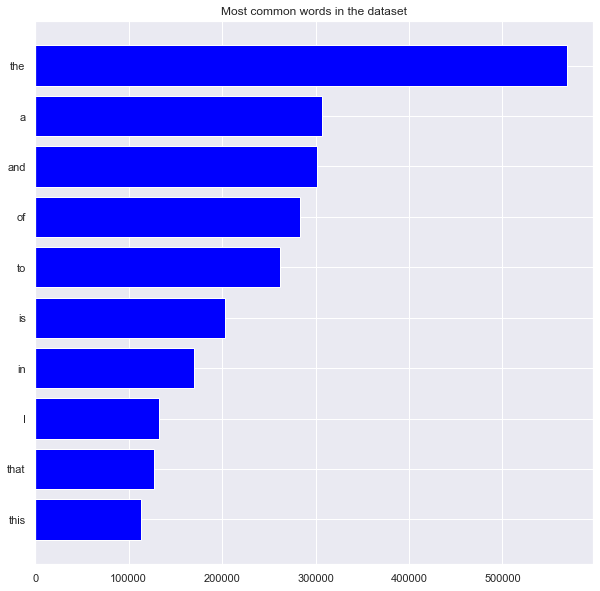

In [88]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()

#### PREPROCESSING

In [89]:
dataframe.isnull().sum()

review       0
sentiment    0
length       0
dtype: int64

In [90]:
dataframe.duplicated().sum()

418

In [91]:
dataframe.drop_duplicates(subset='review', keep='first', inplace=True)

In [92]:
dataframe.duplicated().sum()

0

In [93]:
dataframe.describe()

sentiment        length
count  49582.000000  49582.000000
mean       0.501876    231.350167
std        0.500002    171.542020
min        0.000000      4.000000
25%        0.000000    126.000000
50%        1.000000    173.000000
75%        1.000000    281.000000
max        1.000000   2470.000000

In [94]:
def preprocess(text, pattern):
    if pattern=='[.]+':
        text = re.sub(pattern, '. ', text)
    elif pattern =="[']":
        text =  re.sub(pattern, ' ', text)
    else:
        text = re.sub(pattern, '', text)
    #print(text, '\n')
    return text

In [95]:
dataframe['review'] = np.vectorize(preprocess)(dataframe['review'], '<[^>]*>') #remove markup
#print(dataframe.loc[0, 'review'])
#dataframe.head()

In [96]:
dataframe['review'] = np.vectorize(preprocess)(dataframe['review'], '[.]+') #remove ... and replace with .
#print(dataframe.loc[0, 'review'])
#dataframe.head()

In [97]:
dataframe['review'] = np.vectorize(preprocess)(dataframe['review'], '[0-9]+') #remove numbers and replace with none
#print(dataframe.loc[0, 'review'])
#dataframe.head()

In [98]:
dataframe['review'] = np.vectorize(preprocess)(dataframe['review'], "[']") #remove ' and replace with 
#print(dataframe.loc[0, 'review'])

In [99]:
gc.collect()

3055

In [100]:
dataframe['review'] = np.vectorize(preprocess)(dataframe['review'], '[^\w\s]*') #remove everything that's not word space
# ' is left to handle contractions

In [103]:
dataframe['review'][0]

'One of the other reviewers has mentioned that after watching just  Oz episode you ll be hooked  They are right as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO  Trust me this is not a show for the faint hearted or timid  This show pulls no punches with regards to drugs sex or violence  Its is hardcore in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary  It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda  Em City is home to many Aryans Muslims gangstas Latinos Christians Italians Irish and more so scuffles death stares dodgy dealings and shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes where other shows wouldn t dare  Forget 

In [105]:
dataframe['review'] = [sentence.lower() for sentence in dataframe['review']] #make it lower
dataframe['review'][0]


'one of the other reviewers has mentioned that after watching just  oz episode you ll be hooked  they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go  trust me this is not a show for the faint hearted or timid  this show pulls no punches with regards to drugs sex or violence  its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary  it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda  em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wouldn t dare  forget 

In [106]:
count = CountVectorizer()
bag = count.fit_transform(dataframe['review'])
len(count.vocabulary_)

148992

In [107]:
nlp.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KAMALI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [108]:
stop = set(stopwords.words('english')) #set makes serach O(1)
#originally stopwords.words('english') yields a list
#print(stop)

In [109]:
ps  = PorterStemmer()

In [110]:
def remove_stopwords_and_stem(text):
    text_ = word_tokenize(text)
    tokens = []
    #print(text_)
    for word in text_:
        if word not in stop:
            tokens.append(ps.stem(word))
    #return lemmatization(tokens)
    #print(tokens)
    text = ' '.join(tokens) #send only tokens sent as a joined sentence
    return text

In [111]:
dataframe['review'] = np.vectorize(remove_stopwords_and_stem)(dataframe['review'])
print(dataframe['review'][0])

one review mention watch oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch darker side


#### EXPLORATORY DATA ANALYSIS (AFTER PREPROCESSING)

C:\Users\KAMALI\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


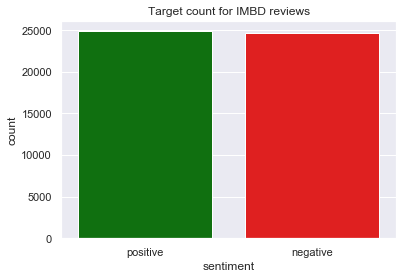

In [112]:
### Count Plot
sns.set(style = "darkgrid" , font_scale = 1,palette='deep',color_codes=True)
sns.countplot(dataframe.sentiment,palette = ['green','red'],order = [1,0])
plt.xticks(ticks = np.arange(2),labels = ['positive','negative'])
plt.title('Target count for IMBD reviews')
plt.show()

In [113]:
print('Positive reviews are', (round(dataframe['sentiment'].value_counts()[1])),'i.e.', round(dataframe['sentiment'].value_counts()[0]/len(dataframe) * 100,2), '% of the dataset')
print('Negative reviews are', (round(dataframe['sentiment'].value_counts()[0])),'i.e.',round(dataframe['sentiment'].value_counts()[1]/len(dataframe) * 100,2), '% of the dataset')

Positive reviews are 24884 i.e. 49.81 % of the dataset
Negative reviews are 24698 i.e. 50.19 % of the dataset


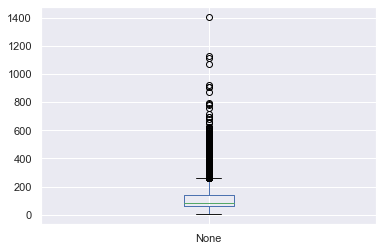

In [114]:
# Calculate review lengths
review_len = pd.Series([len(review.split()) for review in dataframe['review']])

# The distribution of review text lengths
review_len.plot(kind='box')

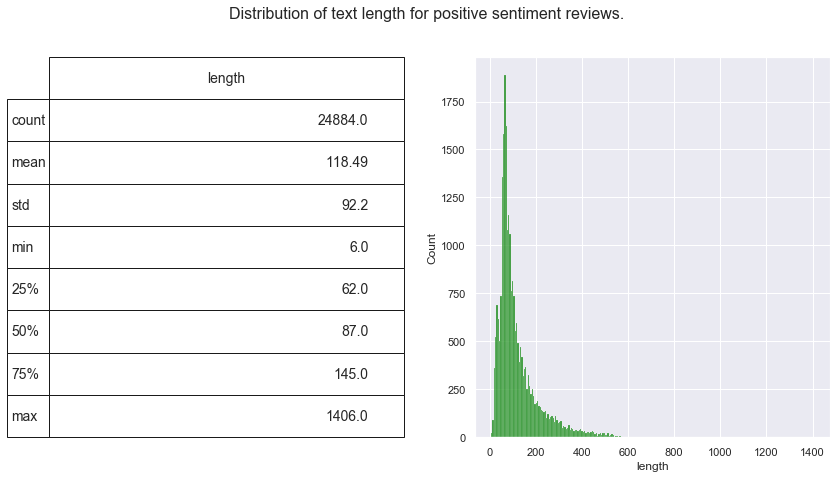

In [115]:
fig = plt.figure(figsize=(14,7))
dataframe['length'] = dataframe.review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(dataframe[dataframe['sentiment']==1]['length'], ax=ax1,color='green')
describe = dataframe.length[dataframe.sentiment==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment reviews.', fontsize=16)

plt.show()

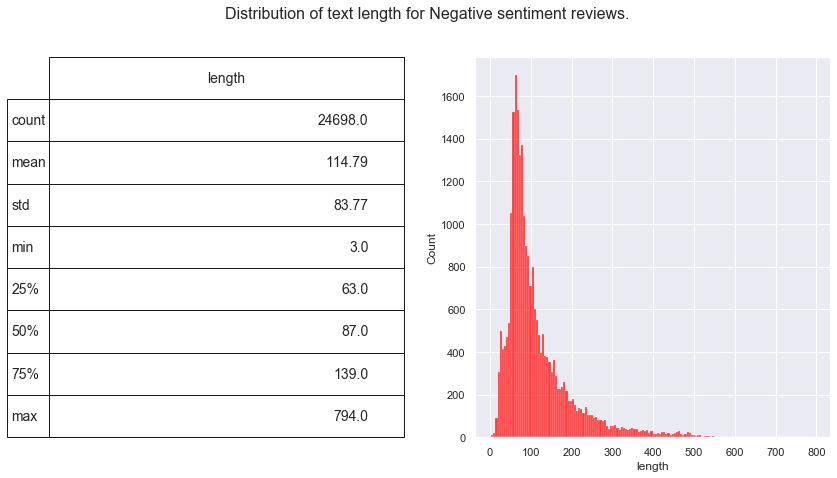

In [116]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(dataframe[dataframe['sentiment']==0]['length'], ax=ax1,color='red')
describe = dataframe.length[dataframe.sentiment==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment reviews.', fontsize=16)

plt.show()

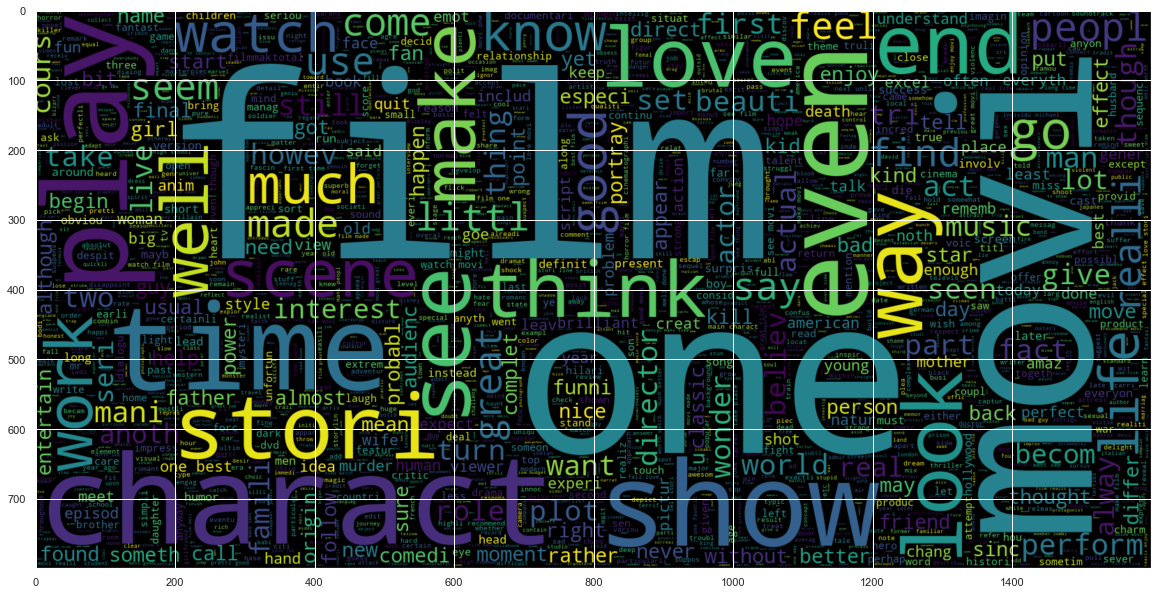

In [117]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dataframe[dataframe.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

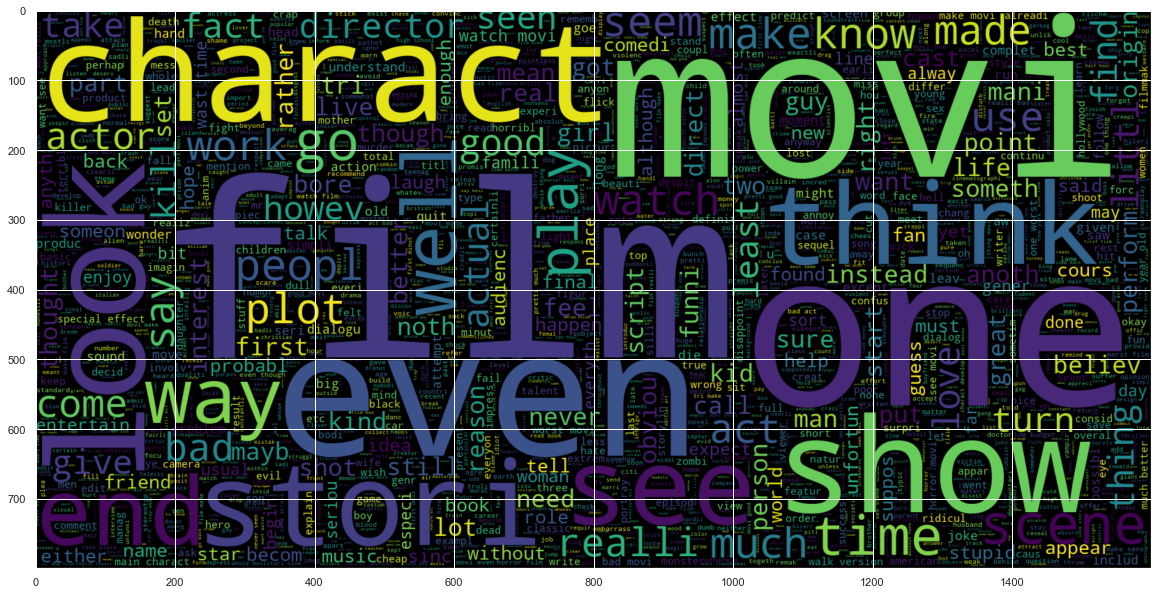

In [118]:
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dataframe[dataframe.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

In [119]:
positive_data = dataframe[dataframe.sentiment == 1]['review']
negative_data = dataframe[dataframe.sentiment == 0]['review']

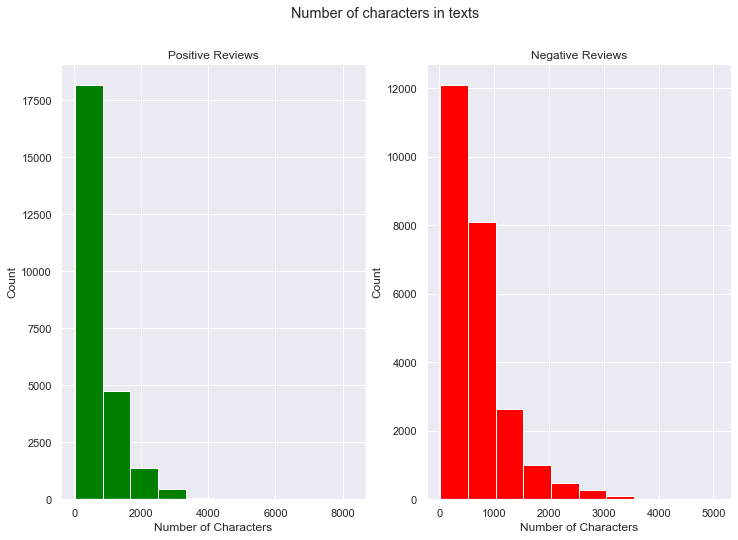

In [120]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Count')
fig.suptitle('Number of characters in texts')
plt.show()

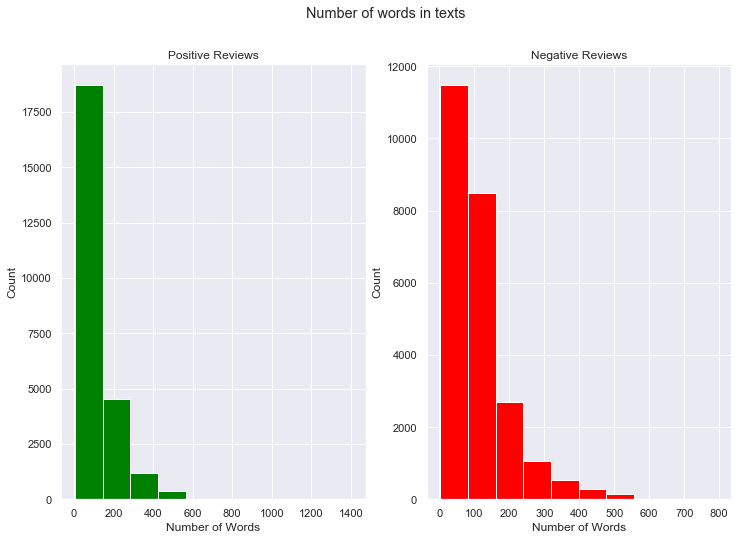

In [121]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in texts')
plt.show()

In [123]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(dataframe.review)

In [124]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

corpus  countv
0     movi  100644
1     film   93521
2      one   53542
3     like   43786
4     time   30558
5     good   29225
6     make   28488
7  charact   27813
8      see   27632
9      get   27602

In [125]:
most_common = most_common.sort_values('countv')

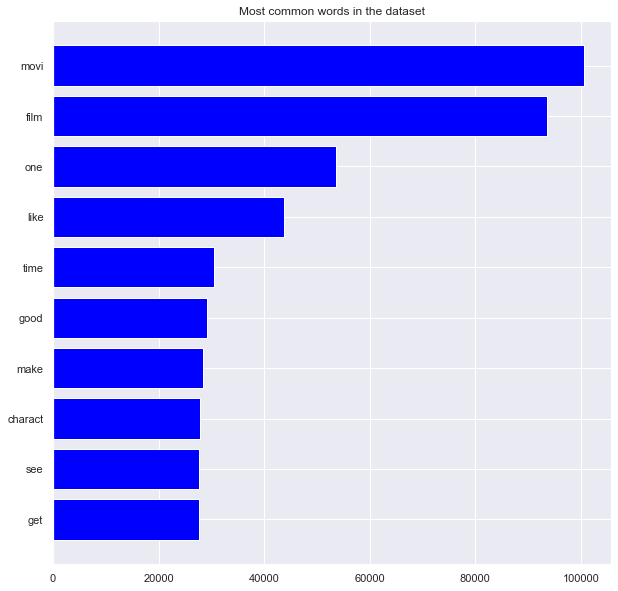

In [126]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()